In [ ]:
#@title Детекция поз после детекции человека

In [ ]:
!pip install -q mediapipe opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 12.8 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade pip
!pip install --upgrade mediapipe opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!pip install -q ultralytics supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 kB 14.8 MB/s eta 0:00:00


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict, deque
from functools import partial
from typing import Callable
from IPython.display import HTML, clear_output
from tqdm.notebook import tqdm
from base64 import b64encode
from PIL import Image

from ultralytics import YOLO

import supervision as sv
from supervision import VideoInfo, VideoSink
from supervision import get_video_frames_generator
from supervision import Detections
from supervision import ByteTrack
from supervision import PolygonZone
from supervision import BoundingBoxAnnotator, PolygonZoneAnnotator, LabelAnnotator, BoxAnnotator

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Подключение Google Диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Ссылка на видео
video_drive = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4'

# Путь к папке на Google Диске
folder_path = "/content/drive/My Drive/video/"

In [ ]:
info = VideoInfo.from_video_path(video_drive)
info

VideoInfo(width=1920, height=1080, fps=30, total_frames=2851)

In [ ]:
#@title Детектируем человека на видео и сохраняем изображения

import pandas as pd
import numpy as np
import cv2
import os

# Путь к видео
video_drive = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4'

# Получение информации о видео
info = VideoInfo.from_video_path(video_drive)
gen = get_video_frames_generator(video_drive)

# Инициализация детектора и аннотатора
detector = YOLO("yolov8s.pt")
tracker = ByteTrack()
box_annotator = BoxAnnotator(thickness=2)

# Создание папки для сохранения изображений, если она не существует
output_dir = '/content/image'
os.makedirs(output_dir, exist_ok=True)

# Обработка каждого кадра
for frame_number, frame in enumerate(gen):
    detections = detector(frame, classes=[0], verbose=False)[0]
    detections = Detections.from_ultralytics(detections)
    detections = tracker.update_with_detections(detections)
    detections = detections[detections.xyxy[..., -1] >= 125]

    # Проверка на наличие детекций
    if detections.xyxy.shape[0] > 0:
        # Находим самый большой объект
        largest_detection = max(detections.xyxy, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))
        x1, y1, x2, y2 = largest_detection  # Координаты (x1, y1) - верхний левый угол, (x2, y2) - нижний правый угол

        # Обрезка кадра по координатам самого большого объекта
        cropped_frame = frame[int(y1):int(y2), int(x1):int(x2)]

        # Сохранение обрезанного кадра
        output_path = os.path.join(output_dir, f'frame_{frame_number}.jpg')
        cv2.imwrite(output_path, cropped_frame)

        # Аннотирование кадра (если нужно)
        frame = box_annotator.annotate(scene=frame, detections=detections)

# Завершение обработки
print(f"Изображения сохранены в {output_dir}")

100%|██████████| 21.5M/21.5M [00:00<00:00, 91.3MB/s]


Изображения сохранены в /content/image


In [ ]:
#@title Детектируем позы
import cv2
import mediapipe as mp
import numpy as np
import os

# Инициализация Mediapipe
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Папки для входных и выходных изображений
input_folder = '/content/image'
output_folder = '/content/image_detect'

# Создание выходной папки, если она не существует
os.makedirs(output_folder, exist_ok=True)

# Получение списка всех изображений в папке
image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]

for image_file in image_files:
    # Чтение изображения
    image_path = os.path.join(input_folder, image_file)
    image = cv2.imread(image_path)

    # Преобразование цвета BGR в RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb.flags.writeable = False

    # Обработка изображения
    results = pose.process(image_rgb)

    # Рисование аннотаций на изображении
    image_rgb.flags.writeable = True
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image_bgr, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Сохранение результата в выходную папку
    output_path = os.path.join(output_folder, image_file)
    cv2.imwrite(output_path, image_bgr)

# Освобождение ресурсов
pose.close()


In [ ]:
#@title Скопируем полученные изображения
import os
import shutil
import random

# Укажите пути к папкам
source_folder = '/content/image_detect'
destination_folder = '/content/drive/My Drive/image/video_3/image_detect'

# Создайте папку назначения, если она не существует
os.makedirs(destination_folder, exist_ok=True)

# Переносим все jpg файлы
for filename in os.listdir(source_folder):
    if filename.endswith('.jpg'):
        shutil.move(os.path.join(source_folder, filename), os.path.join(destination_folder, filename))

# Выводим 6 случайных файлов из папки source_folder
jpg_files = [f for f in os.listdir(source_folder) if f.endswith('.jpg')]
random_files = random.sample(jpg_files, min(6, len(jpg_files)))


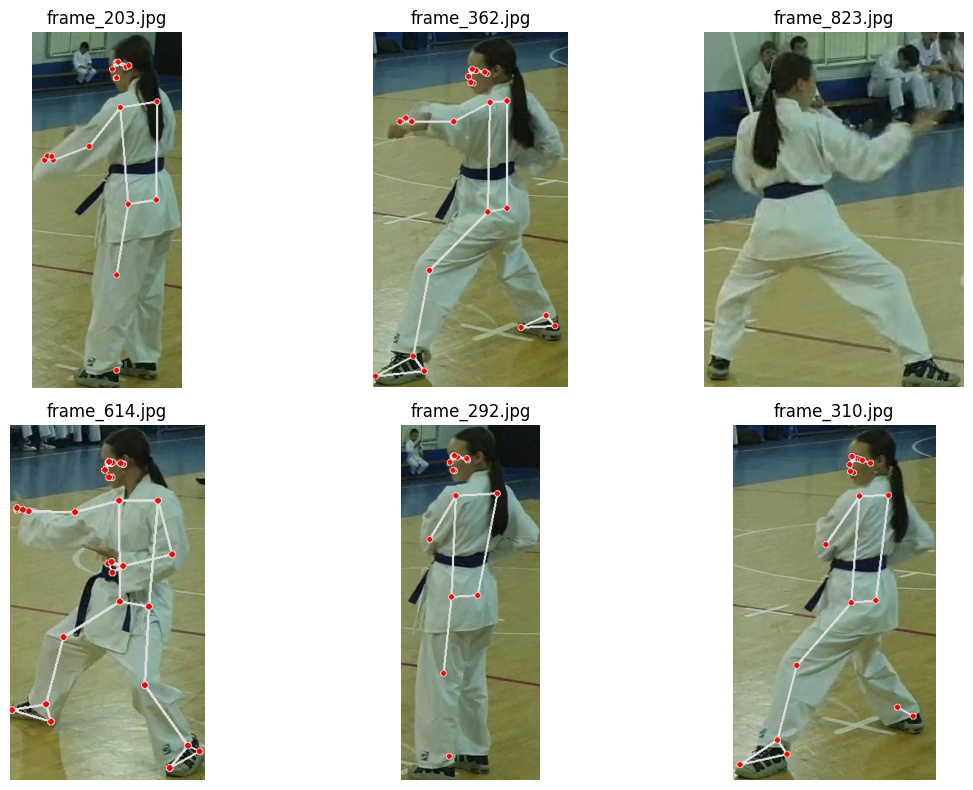

In [ ]:
#@title Выведем 6 случайных изображений
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Путь к папке с изображениями
image_folder = '/content/drive/My Drive/image/image_detect'

# Получаем список всех jpg изображений в папке
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Выбираем 6 случайных изображений
random_images = random.sample(image_files, 6)

# Настраиваем график для отображения изображений
plt.figure(figsize=(12, 8))

for i, image_file in enumerate(random_images):
    img_path = os.path.join(image_folder, image_file)
    img = mpimg.imread(img_path)

    plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца
    plt.imshow(img)
    plt.axis('off')  # Отключаем оси
    plt.title(image_file)  # Заголовок с именем файла

plt.tight_layout()
plt.show()

In [ ]:
#@title Отобразим распознанные позы на видео
import cv2
import os
import numpy as np
import mediapipe as mp
from tqdm import tqdm

# Путь к видео
video_drive = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4'
video_drive_new = "HEIAN_NIDAN_camera_3_sync_pose.mp4"

# Инициализация Mediapipe
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Получение информации о видео
info = VideoInfo.from_video_path(video_drive)
gen = get_video_frames_generator(video_drive)

# Инициализация детектора и аннотатора
detector = YOLO("yolov8s.pt")
tracker = ByteTrack()
box_annotator = BoxAnnotator(thickness=2)

# Создание нового видеофайла для сохранения
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(video_drive_new, fourcc, info.fps, (info.width, info.height))

# Обработка каждого кадра
for frame_number, frame in enumerate(tqdm(gen, total=info.total_frames)):
    # Детекция объектов
    detections = detector(frame, classes=[0], verbose=False)[0]
    detections = Detections.from_ultralytics(detections)
    detections = tracker.update_with_detections(detections)
    detections = detections[detections.xyxy[..., -1] >= 125]

    # Проверка на наличие детекций
    if detections.xyxy.shape[0] > 0:
        # Находим самый большой объект
        largest_detection = max(detections.xyxy, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))
        x1, y1, x2, y2 = largest_detection  # Координаты (x1, y1) - верхний левый угол, (x2, y2) - нижний правый угол

        # Обрезка кадра по координатам самого большого объекта
        cropped_frame = frame[int(y1):int(y2), int(x1):int(x2)]

        # Преобразование цвета BGR в RGB
        cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)
        cropped_frame_rgb.flags.writeable = False

        # Обработка изображения для распознавания позы
        results = pose.process(cropped_frame_rgb)

        # Рисование аннотаций на изображении
        cropped_frame_rgb.flags.writeable = True
        annotated_frame = cv2.cvtColor(cropped_frame_rgb, cv2.COLOR_RGB2BGR)

        if results.pose_landmarks:
            mp_drawing.draw_landmarks(annotated_frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Вставка аннотированного кадра обратно в оригинальный кадр
        frame[int(y1):int(y2), int(x1):int(x2)] = annotated_frame

    # Аннотирование кадра (если нужно)
    frame = box_annotator.annotate(scene=frame, detections=detections)

    # Запись кадра в новый видеофайл
    out.write(frame)

# Освобождение ресурсов
pose.close()
out.release()
print(f"Новое видео сохранено как {video_drive_new}")

100%|██████████| 2851/2851 [24:37<00:00,  1.93it/s]

Новое видео сохранено как HEIAN_NIDAN_camera_3_sync_pose.mp4


In [ ]:
import subprocess

def show_video(path: str) -> HTML:
    path_compressed = path.removesuffix(".mp4") + "_compressed.mp4"

    # Используем subprocess для вызова ffmpeg
    result = subprocess.run(['ffmpeg', '-i', path, '-vcodec', 'libx264', path_compressed], capture_output=True, text=True)

    if result.returncode != 0:
        print("Ошибка при выполнении ffmpeg:", result.stderr)
        return None  # Или обработайте ошибку по-другому

    with open(path_compressed, "rb") as video:
        mp4 = video.read()

    os.remove(path_compressed)

    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""
    <video width=800 controls>
          <source src="{data_url}" type="video/mp4">
    </video>
    """)

In [ ]:
show_video(video_drive_new)

In [ ]:
video_drive_new = "HEIAN_NIDAN_camera_3_sync_pose.mp4"

In [ ]:
#Скопируем файл
# Путь к папке на Google Диске
folder_path = "/content/drive/My Drive/video/"
# Копирование видеофайла в папку на Google Диске
!cp "{video_drive_new}" "{folder_path}"